## Load packages

In [1]:
# enable python linting
%load_ext nb_black

# input dataset
input_file = "../data/all_combined_training.csv"
validation_file = "../data/all_combined_validation.csv"

dfName = "df1"
processed_data = lambda dfName: "../data/" + dfName + "_processed.csv"

model_root = "../artifacts/models/"
data_root = "../data/"
fig_root = "../figs/"
package_root = "../packages/"
root = "../"
DEBUG_MODE = True

<IPython.core.display.Javascript object>

In [1]:
%%capture
import os
import sys

import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller


import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (TransformedTargetForecaster, make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

import pickle
# joblib still saves model in .pickle files
from joblib import dump, load

sns.set()
plt.style.use('bmh')

import warnings
warnings.filterwarnings('ignore')

from PrepPred import prep
Preprocessing = prep.Preprocessing()

In [3]:
# load data
df = pd.read_csv(input_file, index_col=0)
dfc = df.copy()
dfc["datetime"] = pd.to_datetime(dfc[["year", "month", "day", "hour"]])
dfc["date"] = pd.to_datetime(dfc[["year", "month", "day"]])
dfc["kw_cap"] = dfc["Kw"] / df["population"]
dfc.sample(2)
dfc.shape

(236424, 13)

<IPython.core.display.Javascript object>

## Split the dataframe by location and sort by datetime

In [4]:
dfc["lat"].value_counts()
# len(dfc['lat'].value_counts()) # 9

58.45424    26280
62.20071    26280
61.03000    26280
59.31042    26280
62.41657    26280
58.10006    26280
60.01732    26280
55.27987    26232
58.68000    26232
Name: lat, dtype: int64

<IPython.core.display.Javascript object>

We see that there are some missing values in two of the DFs. They are missing by exactly `24*2=48` hours, or 2 days.

In [5]:
key = Preprocessing.create_key()
val_list = Preprocessing.create_valuelist(DF=dfc)

<IPython.core.display.Javascript object>

In [6]:
my_dict = dict(zip(key, val_list))
# my_dict['df1']['lat'] == my_dict['df7']['lat']
my_dict["df8"]

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),datetime,date,kw_cap
0,2013,1,1,0,1314.522302,55.27987,-77.75458,686,1984.209328,-16.415625,2013-01-01 00:00:00,2013-01-01,1.916213
1,2013,1,1,1,1295.379198,55.27987,-77.75458,686,1984.209328,-17.082617,2013-01-01 01:00:00,2013-01-01,1.888308
2,2013,1,1,2,1281.408115,55.27987,-77.75458,686,1984.209328,-16.936621,2013-01-01 02:00:00,2013-01-01,1.867942
3,2013,1,1,3,1229.595401,55.27987,-77.75458,686,1984.209328,-17.152701,2013-01-01 03:00:00,2013-01-01,1.792413
4,2013,1,1,4,1184.894563,55.27987,-77.75458,686,1984.209328,-17.600867,2013-01-01 04:00:00,2013-01-01,1.727252
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26227,2015,12,30,19,1908.782893,55.27987,-77.75458,686,1984.209328,-14.112158,2015-12-30 19:00:00,2015-12-30,2.782482
26228,2015,12,30,20,1848.980827,55.27987,-77.75458,686,1984.209328,-13.717383,2015-12-30 20:00:00,2015-12-30,2.695307
26229,2015,12,30,21,1804.852158,55.27987,-77.75458,686,1984.209328,-14.427344,2015-12-30 21:00:00,2015-12-30,2.630980
26230,2015,12,30,22,1810.590632,55.27987,-77.75458,686,1984.209328,-14.681250,2015-12-30 22:00:00,2015-12-30,2.639345


<IPython.core.display.Javascript object>

In [7]:
my_dict.keys()

dict_keys(['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8', 'df9'])

<IPython.core.display.Javascript object>

## Save the data for later use

In [8]:
for name in list(my_dict.keys()):
    # print(name)
    my_dict[name].to_csv(data_root + name + ".csv")

<IPython.core.display.Javascript object>

## Load data & sort values

In [9]:
df2 = Preprocessing.load_n_sort("df2", data_root=data_root)
df2.head(3)
# df2.info()

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),datetime,date,kw_cap
0,2013,1,1,0,849.450417,62.20071,-75.65,1483,1347.844242,-19.559714,2013-01-01 00:00:00,2013-01-01,0.572792
1,2013,1,1,1,891.025667,62.20071,-75.65,1483,1347.844242,-19.994040,2013-01-01 01:00:00,2013-01-01,0.600826
2,2013,1,1,2,905.738833,62.20071,-75.65,1483,1347.844242,-19.779135,2013-01-01 02:00:00,2013-01-01,0.610748


<IPython.core.display.Javascript object>

In [10]:
df1 = (
    Preprocessing.load_n_sort("df1", data_root=data_root)
    .groupby("datetime")["kw_cap"]
    .sum()
    .reset_index()
)
# df1["datetime"].value_counts()
df1.sample(2)
# df1.shape

,datetime,kw_cap
22700,2015-08-04 20:00:00,0.577236
3614,2013-05-31 14:00:00,0.588989


<IPython.core.display.Javascript object>

## Check duplicated and fill missing values

In [11]:
list_of_orig_dfs = Preprocessing.load_dframes(
    df_name="df", df_enum_range=range(1, 10), data_root=data_root
)
Preprocessing.show_shape(list_of_orig_dfs)

,num_of_rows,num_of_cols
dataframe 0,26280,13
dataframe 1,26280,13
dataframe 2,26280,13
dataframe 3,26280,13
dataframe 4,26280,13
dataframe 5,26280,13
dataframe 6,26280,13
dataframe 7,26232,13
dataframe 8,26232,13


<IPython.core.display.Javascript object>

__Load the dataframes with names `df1` to `df9`__

In [12]:
for i in range(1, 10):
    vars()["df" + str(i)] = list_of_orig_dfs[i - 1]

<IPython.core.display.Javascript object>

In [13]:
# there is a duplicated datetime for df6, but no duplicated rows
# (we can verify this by removing the ['datetime'] col from print() statement)
for i in range(1, 10):
    df = vars()["df" + str(i)]
    print(df["datetime"].duplicated().sum())

0
0
0
0
0
1
0
0
0


<IPython.core.display.Javascript object>

In [14]:
# If we run the following line, we see that df6 is missing '2014-01-05 00:00:00'
# df6["datetime"][8855:8860]
for i in range(1, 10):
    df = vars()["df" + str(i)]
    print(Preprocessing.show_missing_datetime(diff_from=df).shape)

(0,)
(0,)
(0,)
(0,)
(0,)
(1,)
(0,)
(48,)
(48,)


<IPython.core.display.Javascript object>

__We may not want to drop the duplicated row in this case, because the duplication is not in the entire, but only on the datetime, this just means there is an error in the data entry. We just need to change to the correct datetime.__

In [15]:
# this line will show the row with duplicated datetime
df6[df6["datetime"].duplicated()]

df6["datetime"][8832] = pd.to_datetime(
    "2014-01-05 00:00:00", infer_datetime_format=True
)

for i in range(1, 10):
    df = vars()["df" + str(i)]
    s = df["datetime"].duplicated().sum()
    if s == 0:
        pass
    else:
        print(s)

for i in range(1, 10):
    df = vars()["df" + str(i)]
    print(Preprocessing.show_missing_datetime(diff_from=df).shape)

(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(48,)
(48,)


<IPython.core.display.Javascript object>

In [16]:
Preprocessing.fill_missing_rows(df=df1).head(3)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date,kw_cap,datetime
0,2013,1,1,0,1029.780250,58.45424,-78.10301,1757,1662.3844,-18.211905,2013-01-01,0.586101,2013-01-01 00:00:00
1,2013,1,1,1,1017.671833,58.45424,-78.10301,1757,1662.3844,-18.678336,2013-01-01,0.579210,2013-01-01 01:00:00
2,2013,1,1,2,987.965167,58.45424,-78.10301,1757,1662.3844,-18.978430,2013-01-01,0.562302,2013-01-01 02:00:00


<IPython.core.display.Javascript object>

In [17]:
for i in range(1, 10):
    globals()["df" + str(i)] = Preprocessing.fill_missing_rows(
        df=locals()["df" + str(i)]
    )

# If there are still missing rows in any dataframe, the return will be none null
for i in range(1, 10):
    m = Preprocessing.show_missing_datetime(diff_from=locals()["df" + str(i)])
    if len(m) > 0:
        print(m)
        print()

<IPython.core.display.Javascript object>

__This block only needs to run once!__

In [18]:
# for i in range(1, 10):
#     vars()["df" + str(i)].to_csv(data_root + "df" + str(i) + "_filled.csv")

<IPython.core.display.Javascript object>

__======================================================__

In [19]:
list_of_filled_dfs = Preprocessing.load_dframes(
    df_name="df", prop="_filled", df_enum_range=range(1, 10), data_root=data_root
)
Preprocessing.show_shape(list_of_filled_dfs)

,num_of_rows,num_of_cols
dataframe 0,26280,13
dataframe 1,26280,13
dataframe 2,26280,13
dataframe 3,26280,13
dataframe 4,26280,13
dataframe 5,26280,13
dataframe 6,26280,13
dataframe 7,26280,13
dataframe 8,26280,13


<IPython.core.display.Javascript object>

__Load the dataframes with NO missing data into vars `df1_filled` to `df9_filled`__

In [20]:
for i in range(1, 10):
    vars()["df" + str(i) + "_filled"] = list_of_filled_dfs[i - 1]

<IPython.core.display.Javascript object>

In [21]:
for i in range(1, 10):
    df = vars()["df" + str(i) + "_filled"]
    s = df["datetime"].duplicated().sum()
    if s == 0:
        pass
    else:
        print("df" + str(i) + "has duplicated datetime" + s)

for i in range(1, 10):
    df = vars()["df" + str(i) + "_filled"]
    print(Preprocessing.show_missing_datetime(diff_from=df).shape)

(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)


<IPython.core.display.Javascript object>

## Replace outliers

In [22]:
Preprocessing.show_shape(list_of_filled_dfs)

,num_of_rows,num_of_cols
dataframe 0,26280,13
dataframe 1,26280,13
dataframe 2,26280,13
dataframe 3,26280,13
dataframe 4,26280,13
dataframe 5,26280,13
dataframe 6,26280,13
dataframe 7,26280,13
dataframe 8,26280,13


<IPython.core.display.Javascript object>

__Sanity check__: ensure show_outliers() returns the same results when anomaly_window is 3 years long, 

In [23]:
for i in range(1, 10):
    df = globals()["df" + str(i)]
    num_of_std = 3
    col_name = "kw_cap"
    anomaly_window = 365 * 3 * 24

    d_mean = df[col_name][:anomaly_window].mean()
    d_std = df[col_name][:anomaly_window].std()
    low, high = d_mean - (num_of_std * d_std), d_mean + (num_of_std * d_std)
    # the result has to be only False
    print(
        False
        in list(
            df[(df[col_name] < low) | (df[col_name] > high)].index
            == Preprocessing.show_outliers(df=df, anomaly_window=anomaly_window).index
        )
    )

False
False
False
False
False
False
False
False
False


<IPython.core.display.Javascript object>

In [24]:
for i in range(1, 10):
    print(
        "df"
        + str(i)
        + "_filled, number of outliers when anomaly_window is 3 yrs long: "
        + str(
            Preprocessing.show_outliers(df=locals()["df" + str(i) + "_filled"]).shape[0]
        )
    )

# show_outliers(df=df1, num_of_std=3)

df1_filled, number of outliers when anomaly_window is 3 yrs long: 0
df2_filled, number of outliers when anomaly_window is 3 yrs long: 2
df3_filled, number of outliers when anomaly_window is 3 yrs long: 45
df4_filled, number of outliers when anomaly_window is 3 yrs long: 26
df5_filled, number of outliers when anomaly_window is 3 yrs long: 50
df6_filled, number of outliers when anomaly_window is 3 yrs long: 6
df7_filled, number of outliers when anomaly_window is 3 yrs long: 12
df8_filled, number of outliers when anomaly_window is 3 yrs long: 214
df9_filled, number of outliers when anomaly_window is 3 yrs long: 4


<IPython.core.display.Javascript object>

In [25]:
df3_filled.shape
Preprocessing.show_outliers(df=df3_filled).shape
Preprocessing.replace_outliers(df=df3_filled).shape
Preprocessing.show_outliers(df=Preprocessing.replace_outliers(df=df3_filled))

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date,kw_cap,datetime
17872,2015,1,15,16,487.280167,61.03,-69.62,403,463.473224,-27.513586,2015-01-15,1.209132,2015-01-15 16:00:00
18474,2015,2,9,18,487.197917,61.03,-69.62,403,463.473224,-27.216147,2015-02-09,1.208928,2015-02-09 18:00:00


<IPython.core.display.Javascript object>

__Sanity check__: I would think this should return all 0s, however, because the **mean, std** both change everytime we change a value in a series, after we replace the outliers with **mean**, the new series will have different __mean,st__, which might lead to none-0 results

In [26]:
for i in range(1, 10):
    anomaly_window = 24 * 365 * 3
    leng = len(
        Preprocessing.show_outliers(
#             
            df=Preprocessing.replace_outliers(
                df=locals()["df" + str(i) + "_filled"], anomaly_window=anomaly_window
            ),
            anomaly_window=anomaly_window,
        )
    )
    print("number of outliers in df" + str(i) + "_filled: " + str(leng))

number of outliers in df1_filled: 0
number of outliers in df2_filled: 0
number of outliers in df3_filled: 2
number of outliers in df4_filled: 5
number of outliers in df5_filled: 4
number of outliers in df6_filled: 0
number of outliers in df7_filled: 1
number of outliers in df8_filled: 9
number of outliers in df9_filled: 0


<IPython.core.display.Javascript object>

## Save processed dataframes, and verify their ourliers are removed

In [27]:
# # this block only needs to run once.
# for i in range(1, 10):
#     vars()["df" + str(i) + "_filled"].to_csv(
#         data_root + "df" + str(i) + "_processed.csv"
#     )

<IPython.core.display.Javascript object>

__Load the processed dataframes data into vars `df1_processed` to `df9_processed`__

In [28]:
for i in range(1, 10):
    dfName = "df" + str(i)
    vars()["df" + str(i) + "_processed"] = pd.read_csv(
        processed_data(dfName), index_col=0
    )

<IPython.core.display.Javascript object>

In [29]:
for i in range(1, 10):
    print(
        "df"
        + str(i)
        + "_processed, number of outliers when anomaly_window is 3 yrs long: "
        + str(
            Preprocessing.show_outliers(
                df=locals()["df" + str(i) + "_processed"]
            ).shape[0]
        )
    )

# show_outliers(df=df1, num_of_std=3)

df1_processed, number of outliers when anomaly_window is 3 yrs long: 0
df2_processed, number of outliers when anomaly_window is 3 yrs long: 0
df3_processed, number of outliers when anomaly_window is 3 yrs long: 2
df4_processed, number of outliers when anomaly_window is 3 yrs long: 5
df5_processed, number of outliers when anomaly_window is 3 yrs long: 4
df6_processed, number of outliers when anomaly_window is 3 yrs long: 0
df7_processed, number of outliers when anomaly_window is 3 yrs long: 1
df8_processed, number of outliers when anomaly_window is 3 yrs long: 9
df9_processed, number of outliers when anomaly_window is 3 yrs long: 0


<IPython.core.display.Javascript object>

## Hourly resolution

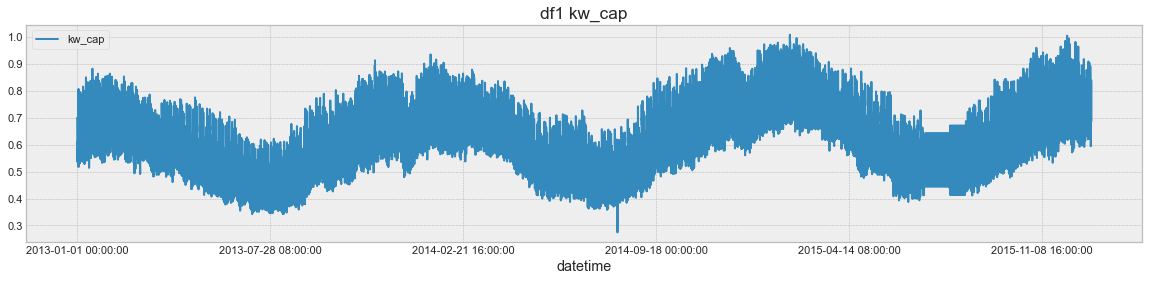

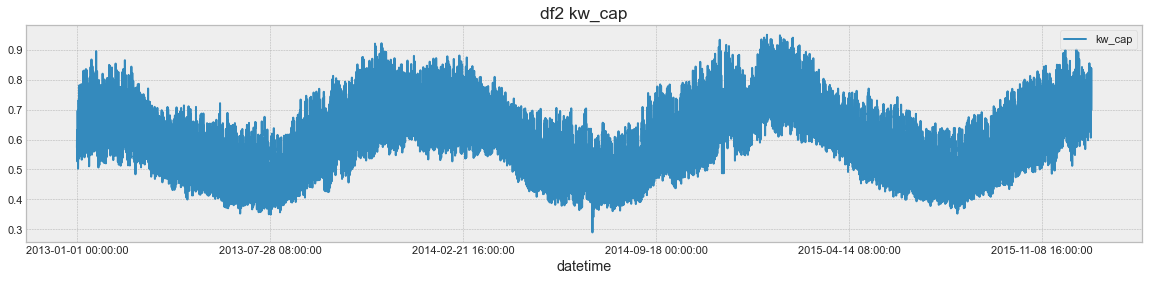

<IPython.core.display.Javascript object>

In [30]:
Preprocessing.plot_dfs([df1_processed, df2_processed], ["kw_cap"])

__Dickey-Fuller test__

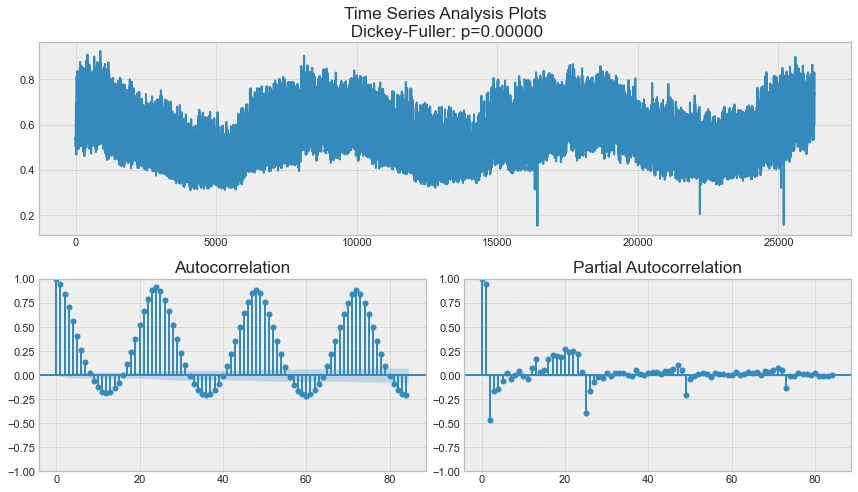

<IPython.core.display.Javascript object>

In [31]:
Preprocessing.tsplot(df9.kw_cap, lags=24 * 7 * 0.5)

## Split the data

In [32]:
# # No more missing data
# len(s1)-365*3*24

<IPython.core.display.Javascript object>

In [33]:
from sktime.forecasting.model_selection import temporal_train_test_split

s1 = df1.kw_cap
test_len = int(len(s1) * 0.2)
s1_train, s1_test = temporal_train_test_split(s1, test_size=test_len)
len(s1_test)

5256

<IPython.core.display.Javascript object>

## Define moving average

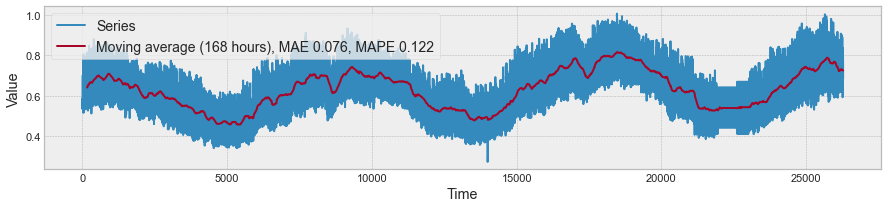

<IPython.core.display.Javascript object>

In [34]:
Preprocessing.plot_mvag_w_data(window_size=24*7, series=df1.kw_cap)

## Aggregate by the date

In [35]:
def data_aggregator(df=df2, groupby_col="date", col="kw_cap"):
    try:
        df_agg = df.groupby(groupby_col)[col].sum().reset_index()
        df_agg = df_agg.sort_values(by=groupby_col)
        return df_agg
    except:
        print("groupby_col and col must be column names")


data_aggregator(df=df2)

,date,kw_cap
0,2013-01-01,14.401937
1,2013-01-02,14.323593
2,2013-01-03,15.207853
3,2013-01-04,15.868703
4,2013-01-05,15.592633
...,...,...
1090,2015-12-27,16.617928
1091,2015-12-28,17.055963
1092,2015-12-29,17.301963
1093,2015-12-30,17.092092


<IPython.core.display.Javascript object>

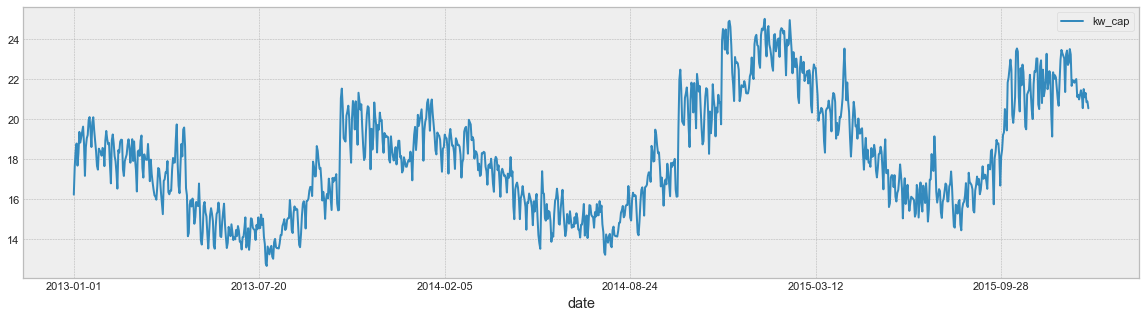

<IPython.core.display.Javascript object>

In [36]:
data = data_aggregator(df=df3).set_index("date")
data.plot(figsize=(20, 5))
plt.show()

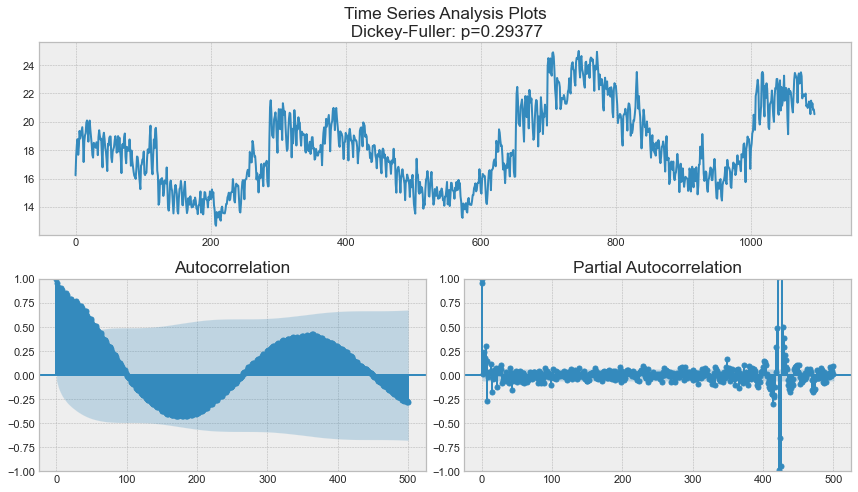

<IPython.core.display.Javascript object>

In [37]:
# # adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80
Preprocessing.tsplot(data_aggregator(df=df3).kw_cap, lags=500)

### It becomes static after taking the difference of 1, what about taking the difference of, say 30?

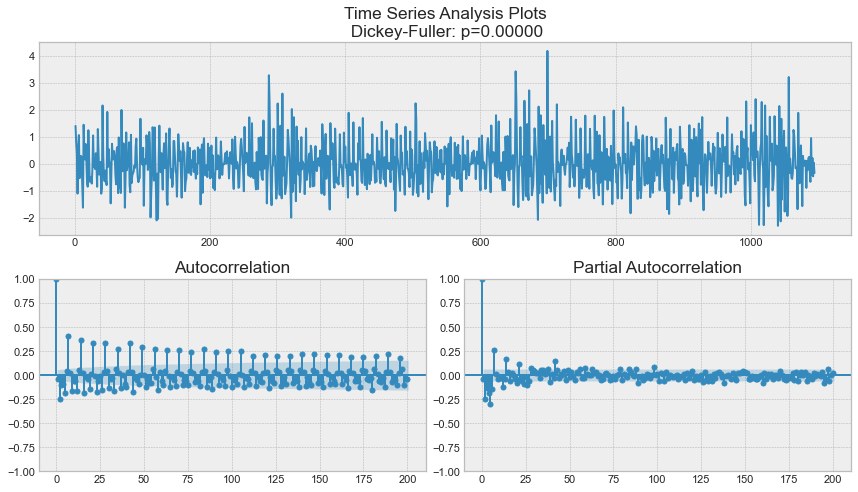

<IPython.core.display.Javascript object>

In [38]:
s2_agg_diff = (
    data_aggregator(df=df3).kw_cap - data_aggregator(df=df3).kw_cap.shift(1)
).dropna()
Preprocessing.tsplot(s2_agg_diff, lags=50 * 4)